# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [40]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

# Function for feature building and extraction on natural language data

In [41]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
#     toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
#     toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['ep_count'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['hell_count'] = toxic_data['comment_text'].str.count("hell") + toxic_data['comment_text'].str.count("HELL") #str.lower() threw an error
    toxic_data['upper_ratio'] = toxic_data['comment_text'].str.count(r'(?<!\s)[A-Z]')#/toxic_data['comment_text'].str.count("\.") #other ways re.findall and looping with isupper returned the same value for each row

#     X_quant_features = toxic_data[["word_count", "punc_count"]]
    X_quant_features = toxic_data[["ep_count", "hell_count", "upper_ratio"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [42]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/agbro/Documents/machine-learning/toxic-comments/toxiccomments_train.csv', my_random_seed=22)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [43]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

C:\Users\agbro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 12916, 'Neg': 114740, 'TP': 6527, 'TN': 56961, 'FP': 57779, 'FN': 6389, 'Accuracy': 0.4973365920912452, 'Precision': 0.10149908251174074, 'Recall': 0.5053422112109012, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [44]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 12421, 'TN': 114058, 'FP': 682, 'FN': 495, 'Accuracy': 0.9907799085041048, 'Precision': 0.9479508509501641, 'Recall': 0.9616754413131, 'desc': 'svm_train'}


### MODEL: logistic regression

In [45]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 12433, 'TN': 114071, 'FP': 669, 'FN': 483, 'Accuracy': 0.990975747320925, 'Precision': 0.9489390932682034, 'Recall': 0.9626045215236916, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 12673, 'TN': 105921, 'FP': 8819, 'FN': 243, 'Accuracy': 0.9290123456790124, 'Precision': 0.5896612693095105, 'Recall': 0.9811861257355219, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [47]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

C:\Users\agbro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 12916, 'Neg': 114740, 'TP': 12428, 'TN': 114076, 'FP': 664, 'FN': 488, 'Accuracy': 0.990975747320925, 'Precision': 0.9492820042774214, 'Recall': 0.9622174047692784, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [48]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 10795, 'TN': 114624, 'FP': 116, 'FN': 2121, 'Accuracy': 0.9824763426709281, 'Precision': 0.9893685271744111, 'Recall': 0.8357850727779498, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

C:\Users\agbro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12916, 'Neg': 114740, 'TP': 0, 'TN': 114740, 'FP': 0, 'FN': 12916, 'Accuracy': 0.8988218336780096, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\agbro\Documents\machine-learning\toxic-comments\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

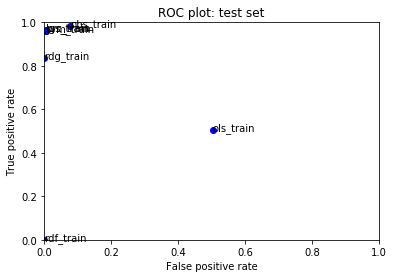

In [14]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

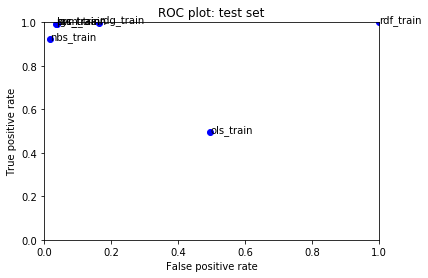

In [22]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FN'] / fit.performance_measures['Pos'], 
             fit.performance_measures['TN'] / fit.performance_measures['Neg'], 'bo')
    plt.text(fit.performance_measures['FN'] / fit.performance_measures['Pos'], 
             fit.performance_measures['TN'] / fit.performance_measures['Neg'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [50]:
ols_predictions = ols.predict(X_train)

In [51]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
0
(UTC) This sentence is an editorial opinion and the information about financing is already included. Being an editorial opinion does not disqualify it per se, but taking account the fact that this is an article about the worldwide company with more than 100-years history, this opinion about one specific aspect related to the company, voiced by non-mainstream magazine, will have undue weight. It may be relevant in some other article (e.g. focused to the climate change denial financing), depending the context.   18:16, 8 January 2016
* * * * * * * * * 
4
could you speak on my behalf regarding this matter, since I have been blocked unfaily regarding this case?
* * * * * * * * * 
70
Request fulfilled by fr:WP user ©éréales Kille® on Fri, 21 Feb 2014 at 20:54
* * * * * * * * * 
131
I've handled the edits in question from the oversight end of things. In the future, it's definitely better to contact the oversight team privately in cases involving private informa

1567
"

I tried to do a little bit of research as to where an appropriate place for this information would be.  I would start by asking a question at Wikipedia talk:Wikipedia Loves Libraries.  Hopefully they will be of much more help than I have been.   (spin me / revolutions) "
* * * * * * * * * 
1569
Also Tribute To The Troops has been nominated for deletion.
* * * * * * * * * 
1735
Observation Only 

I have quietly observed the tension concerning my brother Jeff Merkey and all Native Americans on Wikipedia.  It seems that Mr. Jimbo Wales has challenges with Native Americans.  If so, the problem is his and not a problem of our people.  Mr. Wales doesn't seem to like it when anyone has a difference of opinion that himself.  This is a narrow minded approach and is his problem.  There are numerous others here that seem to be on the same infantile path as Mr. Wales.  This is most unfortunate.  I will again set back and observe.  These comments are of my own doing and not a product of any

3395
REDIRECT Talk:Universidad, San Juan, Puerto Rico
* * * * * * * * * 
3402
Absolutely hysterical.  Go get consensus on the Mendelssohn talk page.  Using reliable sources.  And knock off the disgusting personal attacks, please; that includes ad hominems such as attempting to dissect my motives.  Have a nice day,  (talk)
* * * * * * * * * 
3403
You want to have a little read of wp:AGF, but don't worry, because that is a bridge we will cross in good time.
* * * * * * * * * 
3498
"

Sockpuppetry case
 
You have been accused of sockpuppetry. Please refer to Wikipedia:Suspected sock puppets/Dtemkin4 for evidence. Please make sure you make yourself familiar with notes for the suspect before editing the evidence page.   "
* * * * * * * * * 
3549
Agnostics Category? 

Is she agnostics? I thought she went to cathorlic schools,
* * * * * * * * * 
3552
"I think the information given in Wikipedia about the languages ​​spoken in the Sahrawi Arab Democratic Republic is manipulated, only reports th

5089
Sorry. 

Sorry Dgw for my outburst, but I really want to know why Jews want to wipe out the white race? Why do you hate us so much?
* * * * * * * * * 
5123
I'll see how I feel at this time tomorrow. ← What's up, Doc? carrots→
* * * * * * * * * 
5168
Further to the idea of who wants to battle, you'll notice that I asked Nick to comment, not you.
* * * * * * * * * 
5175
Jamarks-
I observed that you had edited the article Bicycle Ride Across Georgia before I completed the article recently. I have a question for you. I have linked many related items to the article and in my opinion all bases have been covered for the orphan tag to be removed. I asked if the tag could be removed on the talk page for the Cycling project and someone told me that not enough articles have been linked, but the Wikipedia:Orphan article says only three links are necessary. Seeing as you are an experienced user on Wikipedia, I am asking for your advice. Can I remove the tag? Thanks.   20:38, 9 November 2009
* 

6321
Leaf 

The last few days I have been working in this article. I think it is now optimal. Could you take a close look at it and  rephrase where necessary.   19:14, 3 Nov 2004 (UTC)
* * * * * * * * * 
6413
Castroism? 

I think the castroism link should be removed. It just leads to the Fidel Castro Page and I have never heard of it being used before.
* * * * * * * * * 
6424
and yes michael wrote most of his music himself from Bad onwards
* * * * * * * * * 
6452
1. I most certainly do not agree to removing my comment altogether, yet I would gladly edit any personal attack that I may have not noticed.
2. I agree.
3. As long as Tiamut agrees not to get into an edit war as well, and to not speak on behalf of a non-existing authority and then - upon her sole decision backed by you (with all due respect, you're not an expert here), I certainly don't see any reason to get into an editing war. In any case, I shall refrain from doing it in such a way.
* * * * * * * * * 
6475
Box Art 
Even so,

8423
"

please get a WP username and sign your posts.  anyway, i think the sentence could be improved but (even though i don't use the term), the ""decibel spectrum"" has already had a logarithm applied to it.  you don't want to apply the log to the log of the spectrum.  "
* * * * * * * * * 
8481
"
Oh ok, sounds good. talk "
* * * * * * * * * 
8498
"

Osli, pls refrain from aggressive actions as removing sourced parts as in Naser Orić article or articles related to Srebrenica genocide. I showed what you did, so it is not about my language, it is about explaining your actions which are in my opinion not correct, because first you removed sourced part, then you said that you didn't do it, when I proved it to you, you accussed me of ""aggressive language"". Regards. "
* * * * * * * * * 
8524
)

 There is a scene in the last book of the Corwin cycle where this is explicitly stated (by a talking jackal, of all things.
* * * * * * * * * 
8547
"

Wikilinks
How territorial of you to undo all m

9892
, and this should be taken into account in the article
* * * * * * * * * 
9939
"

 3RR 

Hey be careful about WP:3RR on The Hangover Part II. I agree the currencies should be converted, since the film is an American film and the rest of the currencies used in the article is US dollars.  Might want to take it to the talk page.  Admins take 3RR pretty seriously and will issue a 24 hour block. — Allen  "
* * * * * * * * * 
9994
Boudhanath also now refers to the whole area or surrounding neighbourhood. A more specific title like Boudhanath Stupa might be better.
* * * * * * * * * 
10023
"

Since you also used this account for vandalism I have directly blocked it as well. Chillum "
* * * * * * * * * 
10137
I like that daft very much, looks far better. I welcome this format to the walmart entry. Maybe with this Rebuild we can purge some of the POV that are very much built right into the entry after years of POV being inserted as facts.The Ace!
* * * * * * * * * 
10140
"

This IP address

11165
Do you read the comments I make or just make continue to press with your accusations ignoring all comments?
* * * * * * * * * 
11176
"

While I disagree with your opinion that I was heavy handed or was in any violation of wikipedia policies, I'm all for promoting local artists and finding real talent to listen to, Wikipedia is not the place. Your original argument was that it was informative, but I'd like to remind you once again, that the main reasoning for my behaviour in removing it was that ""Wikipedia is not a directory of everything that exists or has existed."" I have also requested that if you continue to pursue the issue was that you do so within Wikipedia's content guidelines. You provided examples of cover lists, which I think are great examples, and I think a section in the same vein would be awesome, but should be done with similar criteria. Finally, SineBot is signing your posts because you aren't doing it correctly, just click the signature button (3 to the right o

13204
Rodney MacDonald 

Are you a fan? Can't you accept the first and only gay premier?137.240.136.80
* * * * * * * * * 
13289
Gwen, on reflection I accept the manner in which I attempted to air the issue of Offliner's nationalistic outlook on the article talkpage after Offliner proceeded to strip all non-Russian viewpoints from the article lead was somewhat brusque and could be construed as a personal attack, and will certainly be more careful in my choice of words in future. 
I'm not alone believing this was not a case of outing, and making unproven allegations of misconduct, in this case outing, is also a form of personal attack designed to undermine the other editor, and Offliner has been warned in the past not to file such vexatious claims. Offliner is a veteran of filing complaints on WP:AE, and if this comes under WP:DIGWUREN (and Kuril Islands dispute seems to fall outside of the scope of that case being Eastern Europe), he should know that board would have been the more appro

=="
* * * * * * * * * 
14484
"

 File:Kid_Pix_1.0_About.png listed for deletion 
A file that you uploaded or altered, File:Kid_Pix_1.0_About.png, has been listed at Wikipedia:Files for deletion. Please see the discussion to see why this is (you may have to search for the title of the image to find its entry), if you are interested in it not being deleted. Thank you.   "
* * * * * * * * * 
14563
Please do not put false information 

How dare you those people who switched alana and mel's names for nathan and tyler's names when i looked a few days ago. Seeing Nathan and Tyler's namea on the eliminated list nearly made me so angry! How could they have done so well and then failed? But then I realised that Alana and Mel were not eliminated as shown in the latest episode. Now I check today and everything is as I thought. Nathan and Tyler were NEVER eliminated! So those ppl who put up false information, please the table of elimination results should not be messed around with.
* * * * * * * * 

16145
Colt Cabana 

lol, you're joking? He actually has a move called butt-butt?? Can't be right, surely?!?!
* * * * * * * * * 
16182
"

Thank you! I had thought of ""brother officer"" but the age difference seemed too great. Anyway, that's solved. Thanks   "
* * * * * * * * * 
16207
Hey no probs. You will be able to align better than any other other contributor. Thanks a lot for your help.
* * * * * * * * * 
16261
Wired article about project chanolgy and /b/ 

here. I'm surprised nobody had added anything from this yet, seeing as it came out a couple months ago, and because it has a lot about 4chan and project chanology.
* * * * * * * * * 
16293
Ranze, there was no harassment or disruption. Note the lack of examples (diffs), or, if a diff is provided (which I did), read through it.  Nothing there deserved a block.  WP is broken.
* * * * * * * * * 
16312
I'm denying BLP violations.
* * * * * * * * * 
16343
"

Resident Evil 5
Hello.  As the RE5 page has been protected, please take your 

17844
February 2006 (UTC)

Yes.. I just realized I wrote 600 BCE, which is ridiculous.  Sorry about that.  And furthermore, I think you're right, there are written records of Japan pre-dating Himiko.  I'll have to read some more to be able to write something meaningful.. someone else mod it in meantime?  19:56, 11
* * * * * * * * * 
17917
"

 Other artist to be brought up for consideration (if only to be kept off the list!) 

Some artists that may need to be explicitly stated whether or not they belong on the list:

Deadsy
The Birthday Massacre
Deadstar Assembly
Within Temptation
 Voltaire
Cinema Strange (Speaking of which, what happened to their article?)
Murderdolls
Wednesday 13
The Dresden Dolls
Dead Inside the Chrysalis
Nine Inch Nails

No, I don't think that any of these belong on the list, but they will make excellent additions to the ""Previously discussed artists"" list."
* * * * * * * * * 
18009
"grandson not ""Tenzin Yeshe Dorje Rinpoche"""
* * * * * * * * * 
18102
Hi! Maybe 

19680
Ownership 

Who owns Taransay?
* * * * * * * * * 
19708
, 12 July 2008 (UTC)

I get what the opposition means with dumping, but it would not be good for someine with a laptop or dial-up having to go to several articles to get what they are looking for. This would not be good for a laptop CPU either, with it having limited storage. I am using a laptop and I can edit it just fine, with having Windows 95 at school and can edit the article easily also. I strongly support this cause and it should be done in my veririable opinion.   17:20
* * * * * * * * * 
19767
—The preceding unsigned comment was added by  (talk • contribs) 16:01, 23 December 2005  (UTC-8)
* * * * * * * * * 
19780
SHAZAM  is an acronym 
SHAZAM is an acronym for various historical or mythilogical persons such as Solomon and Atlas, etc and their qualiies , ie:Solomon's wizdom, Atlas's strength, etc.  Hercules? I forgot them all.  Billy Batson was a crippled newsboy - perhaps later on he became a reporter, but I only re

21517
"
 By that, I mean that the capitalised ""The"" in ""The Bowery"" is no longer a problem in the articles that you have mentioned. I've been blocked now for one day for edit-warring with BMK, but I would like it if you notify me of any mistakes like this in the future. Thanks,  (give him tirade • check out damage) "
* * * * * * * * * 
21576
Your personal attack is noted
* * * * * * * * * 
21621
Arvanitas are autochthones 
Karaguni withour ‘s’ you have got a original Arvanitiki surname , do you consider yourself autochthones ? If yes give me support in article  Arvanites and do not delete my statement. Dodona
* * * * * * * * * 
21774
Yet another locked article. What is with the NDP, first they smeared Hunter when he was alive and now they send their wikipedia attack queers to make certain that the truth is not mentioned here.
* * * * * * * * * 
21915
, 30 November 2007 (UTC)
Thank you! 18:24
* * * * * * * * * 
21925
"
 Yet we do just that at Aloe. Suggesting similar treatment.   di

Erm... And the point is?
* * * * * * * * * 
22410
"

 United States 
Hey Cal!  I am writing is to let you know that there will be no more United States edits from me!!
Thanks for reverting my inappropriate rubbish, comrade.  No sarcasm intended here.  I will now try to find something else to do.  Have you any positive suggestions?    Talk   "
* * * * * * * * * 
22450
"

I (someone else) would recommend against the use of the term ""facing."" While there are many regional term variants, I've never heard or read of this one. It would be perhaps better to refer readers to the following terms (where they will be able to find a lot of information):
 * engraving - using small chisels (gravers) to carve line art into metal.
 * chasing - using small blunt rods to drive particularly shaped grooves into sheetmetal.
 * repoussé (embossing) - using chasing tools and a pitch bowl to shape sheetmetal into bas-relief artwork from the backside of the metal."
* * * * * * * * * 
22458
You seem to be the

24088
C'mon, who really checks references? Me myself didn't, until yesterday
So- as you admit- people do look at reference dates. After all, this is what you yourself just did.
* * * * * * * * * 
24130
Stalin could NEVER have been impersonated!  Through being born within the borders of Russia, he was not ethnically Russian but Georgian.  (As languages they are completely unrelated.)  His original name was Iosif Dzjugasjvili.  A possible look-alike could not have had, or even ACQUIRED, the same language skills!  His family and close friends would NOT be fooled.  The description of “Rashid” is not credible.  The claimed physical resemblance is to close to be true.  Furthermore, if he died in 1991 at the age of 93 he would have been born in 1898.  That would in turn make him 20 YEARS YOUNGER than Stalin!  Obviously, the author does not know what he/she is writing about.

2006-11-13  Lena Synnerholm, Märsta, Sweden.
* * * * * * * * * 
24140
"""Heather LaCunt"" has also been trolling the LI

26315
PSP updates post reverted. 

I dont know why did you reverted my post about PSP updates.
Post is correct, if you know nothing about PSP firmware is not my problem.
* * * * * * * * * 
26317
I'm not a programmer, but here's the next best thing:  .
* * * * * * * * * 
26359
No worries, I actually copy-edited two articles, but it seems when I added link on the blitz page, I added a typo so it didn't link across. Anyway, have a good day. Regards,
* * * * * * * * * 
26388
"

 Heads up 

See this ANI thread about your old user and talk pages. ''''''87 "
* * * * * * * * * 
26455
The numbers in parentheses are the additional decimal points which have been measured but lie outside the accuracy of the measurement process. This means the values in the parentheses eg (15) could be used for the purpose of calculation, but any value that results from such a calculation would not be more accurate than the number of significant figures if those in parentheses were not considered. In other words, t

29081
Dear  aka John E. McLaughlin,
It is spelled as Kyiv in English language because:
1) Ukrainian government insists on Kyiv spelling
2) The State Department of the U.S. issued a directive to write Kyiv
3) The Prime Minister of the U.K. calls the city Kyiv
4) United Nations Multilingual Terminology Database (the ultimate body on geographical names) approved it as Kyiv
5) Major English speaking governments worldwide switched to Kyiv spelling
6) CIA refers to the city as Kyiv
7) The name of the famous football club is Dynamo Kyiv
8) Many papers, e.g., British The Guardian, are already writing Kyiv
9) All major Canadian media already use the spelling of Kyiv
10) and many more reasons http://kyiv.of-cour.se/
(  )
* * * * * * * * * 
29101
"

 Are you an admin, Lomn? If so, a little help? 

An admin by the name of User:Freakofnurture seems to have had a really bad time lately and when I try to reason with him and make him feel better towards me, nothing good came out of it. Evidently, othe

30257
Reply to FyzixFighter 

FyzixFighter, you are making some of the same mistakes as Brews. You seem to think that we can take that four part expansion of acceleration in terms of polar coordinates and read some physics into it. We can't. The polar terms tell us nothing about any particular motion.

But they are nevertheless very useful. We can use the expressions in a properly modelled differential equation that involves real physical input. The radial convective term is used as a centrifugal force in the two body gravity problem.

You seem to think that because it is derived with a negative sign that it has to mean centripetal force. That is not so. The negative sign is a consequence of the outward positive convention for the position vector.

The expression is merely the mathematical form for a force that changes the direction of motion and acts in the radial direction.

When we construct the planetary orbital equation, we end up with a radial gravity force inwards and a centrifu

32420
" as well as being a member of the Uluslararasi stratejik arastirmalar kurumu (USAK). He said ""OK. I am not, and I have never been, a temporary intern in USAK—another error of the “report”. I am a full time researcher in this think-tank. That is true that I have for the moment no personal page on the Internet site of USAK, but it should change soon."" "
* * * * * * * * * 
32446
THE MOST HIGH MINISTRIES
* * * * * * * * * 
32458
There is no free speech on Wikipedia?
You are nuts, there is a lot of freedom of speech in the US and you abide to that.
You can't just make a law that will prevail over the US constitution. Unless you are willing to rewrite the bill of rights, for that we have to kill Dr MLK jr. again.
You allowed this computer hacker Pablo something, located overseas, probably in some garage in a little town in a country called argentina to ignore, laugh at our bill of rights.
He censored my contributions, probably he could not even understand what was in those, his comm

34566
Okay, if you would grant it, please go ahead. I'd like to see how it works. Thanks! -
* * * * * * * * * 
34567
(UTC)

As this appears to be the only source upon which any of our material on Rodryg Dunin can be based, it would be ideal if the translation at which we'd arrived can be shared here on this page. 20:02, 21 October 2007
* * * * * * * * * 
34615
Looks like the page has been vandalized. Someone who knows how to revert should probably do so.
* * * * * * * * * 
34622
well done 210.50.244.166, can't believe my work was undone
* * * * * * * * * 
34627
Please read the article. You will see that I'm only attempting to improve upon it.
* * * * * * * * * 
34657
Your removal of sourced information from the article Van Morrison is disruptive. Please stop. ''''''
* * * * * * * * * 
34660
The myth that Robert the Bruce offered safe haven to the Templars has also crept back in.  In fact, the most that can truthfully be said about that is that Robert I perhaps didn't prosecute the Temp

You said you're ""not sure such a large quotation from him in this article is appropriate"". Well, I and Intangible and Theindividualist do think it is appropriate. Vision Thing can't be here right now, but something tells me he would think it's appropriate, too. duck talk "
* * * * * * * * * 
36961
Pix
You inspired me. Nice picture of the Venezuela sign. I was surprised to see how old it was, and that it was orphaned.
* * * * * * * * * 
36971
"
If it helps, the insult was directed at you, the other fellow who agreed to remove the images, and a large percentage of the editors at Wikipedia, who spend more time citing rules than actually making substantial contributions. There is nothing warped about my view.  I am no more ""stealing"" images than the IGN or Gamespot or 1UP article that does the same thing.  Even Sega itself would not complain about the use of these images in this way, as the article only promotes their product.  But the editors here are so busy trying to lord over eacho

39325
2012 (UTC)

Hamas is a terrorist organisation that acts as a proxy for Iran. Why is that not in the article? Because Wikipropaganda is biased. 109.157.82.51  15:12, 18 November
* * * * * * * * * 
39380
A second editor has redirected it once again, so it would seem the consensus supports redirecting it. What is more, the article is not being deleted, it is being redirected: there is a difference. Finally, you don't initiate AfD to change something that clearly doesn't meet the notability policy to a redirect. The other three artices were sent to AfD because not only are they non-notable but there is nothing to redirect them to.
* * * * * * * * * 
39435
SandyGeorgia

I have just sent you an email on this. I am afraid I have been telling nothing but the simple truth all along, except I had no idea of her identity (and personal agenda with me) until yesterday.

You must do what you have to do, but so must I, morally, apart from anything else, and if you persist in trying to force me 

41973
Wikipedia:WikiProject Iraq 

I hope that the approval of the page above meets with your approval.
* * * * * * * * * 
42029
Please do not remove content from Wikipedia; it is considered vandalism. If you want to experiment, please use the sandbox. Thank you.     • talk
* * * * * * * * * 
42104
article (first level warning) >
* * * * * * * * * 
42115
Sources  

As none of the global warming sources are reliable and unproven, is it safe to give another view on this article. I can provide many sources which throw out the global warming theory and are as reliable as the ones that show it as real. Sources such as Earth is not meant to have polar icecaps and only does when in an ice age and coming out of one, the majority of the earths life has had no icecaps. Don't want to edit without discussing it first, anymore warning and I won't be able to edit at all.
* * * * * * * * * 
42124
. now after reading all this, lets sleep ;)
* * * * * * * * * 
42208
I didn't know about this past relati

* * * * * * * * * 
44446
"
It looks like everything is in order. I'd name it ""Minsk Protocol"". For a description, one can say ""A map of the buffer zone established by the Minsk Protocol during the War in Donbass"". For categories, put it in the ""War in Donbass"" Commons category. Thanks once again for your prompt work!  — ☎ "
* * * * * * * * * 
44496
Your way is overly convoluted, difficult to read, and way too loosey goosey on the one away list.  Please limit one aways to guys who are at least semi-active.  Santino is long retired.  The way things were was fine as is with no complaints...if it ain't broke, don't fix it.   When you have 2 editors telling you to back off, then it's kinda time to fold 'em.  (talk)
* * * * * * * * * 
44504
I don't know why you are leaving hostile notes on my talk page, but I suggest you approach admin if you have an issue with me, as I have no wish to communicate with you in the form of private messages. If indeed it is necessary to relay issues in th

46612
Medical student 

Jayanika Dilshan 
MED / 07 / 08 / 140 
Faculty of Medicine
University of Rajarata
jayanika88@gmail.com
* * * * * * * * * 
46650
"

 Dogs 

One question, how many dogs do you need to make a ""pack"" ... three, four, five ... a dozen? Do they not live in three and fours too?

So, should it be, ""They may live in packs, fives, fours, threes, pairs, or singly""?

The point I am making is this, you made a canonical statement in your summary, ""no evidence ... etc"" but you did not provide any evidence or reference to sustain it in your edit. 

Can you do so?

The reason I am writing this is because I spent some time cleaning up and developing the Indian pariah dog topic, which I am sure you know. It's obviously a topic which you have some interest and passion in, perhaps even want to promote, which is a good thing. 

But isn't content on the Wikipedia supposed to be supported by references? You may well be right, but you know that's not enough.

I am actually interes

49894
"

 Please do not add unsourced content, as you did to Latin American Canadian. This contravenes Wikipedia's policy on verifiability. If you continue to do so, you may be blocked from editing Wikipedia.   talk to me 
If this is a shared IP address, and you didn't make the edit, consider creating an account for yourself so you can avoid further irrelevant notices."
* * * * * * * * * 
50017
Sky Tower

Hello. I have used one of your images to make a collage with another one of mine. Hope you like the result. Cheers!
* * * * * * * * * 
50145
Well then thank you. You can disregard my previous statement and do whatever you want. If you think you will change the world by trying to delete true matters then WE all lose in the long term. Thanks for your time. Best of luck. Cabbynet.
* * * * * * * * * 
50174
the crew at pacific wre outstanding. headed by Bill Reed they included Art Margain .Frenchy. Dean. Gary Schultz. Frenchy went on to work for the Grateful Dead/ Gary Schultz went to the 

* * * * * * * * * 
52066
Dry glue 

You declined the speedy but left the tag on.  Any objections to me taking it off - I found a load of info sitting in the Van der Waals force article which I have moved into this one.
* * * * * * * * * 
52154
Recent Geonotice.js edit 

Please be careful about the commas in JS pages. This is the most common cause of JS errors.
* * * * * * * * * 
52288
There would need to be a citable source for such a statement 209.181.16.93
* * * * * * * * * 
52305
Complex Iteration 

I've discovered that not only fractional iteration is possible, but also complex iteration. It's not as intuitive as fractional iteration, but it does make sense once you have a new model for what iteration means. Probably the simplest explanation is with orbitals in the complex plain: iterating to a real values generates the complex orbitals as paths. Iterating to imaginary powers, meanwhile, generates paths perpendicular to the orbitals at every point. You need the entire vector field 

55559
"

 Daniel Quinn / B 

Daniel Quinn described in his book ""The Story of B"" an interesting idea of who the Antichrist is. Basicly it's based on John's statements. To make it short: according to Daniel Quinn the Antichrist is or are those, who love the world. Like John said that those, who love the world, don't have the love to God in them. Daniel Quinn also says that the Antichrist is more like an anti-saviour. If you wish, I could write something about all these ideas on the mainpage here. I just wasn't sure if I should do it or not.  0.39, 25 August 2006 (CEST)"
* * * * * * * * * 
55584
So this could be the start of a long-term issue between us.
* * * * * * * * * 
55606
Either way, its better than a facist president. Left-Wing Power!
* * * * * * * * * 
55701
Wikipedia:Wikipedia Takes the Australian War Memorial  

Hi.  You're invited to Wikipedia Takes the Australian War Memorial on 25 August at the Australian War Memorial.
* * * * * * * * * 
55718
You're doing it again. Stop 

58706
Four more words

I've added four more words, highlighted in red above. Go ahead, put that hair under the microscope and split it again. You're clearly trying to protect the selfserving press release crap, and keep out any mention of the FBI investigation or the 26 indictments and convictions, until after the election. 

Strong support.
* * * * * * * * * 
58908
download

    I am downloading the PPV now, but all the reports I have read say it was just Edge. TJ Spyke 
back in january u posted this, i just wanted to know were u download from cus i cant find the download
* * * * * * * * * 
58911
FYI, I removed the move tag for this article since it's gone a few days past the usual WP:RM expiration date.  Also, none of the moved proposed here are obstructed so no admin assistance is needed.  Once you've all decided on a new article name, if you want to move the dab page over the top of this one, let me know and I can do that.  —
* * * * * * * * * 
58916
"

This is arbitary.
If you loo

60087
"

 two comments: 

1. I think someone already said this right, but to be more specific, supervenience physicalism is what the zombie argument turns on. Other versions of physicalism e.g., token physicalism, could be compatible with the mere possibility of a zombie. 

2. The section on inverted qualia and the ""neurosurgical prank"" is wrong. See in Dennett's online Quining Qualia, ""In this version, intuition pump #5: the neurosurgical prank, the experiences to be compared are all in one mind. You wake up one morning to find that the grass has turned red, the sky yellow, and so forth. No one else notices any color anomalies in the world, so the problem must be in you. You are entitled, it seems, to conclude that you have undergone visual color qualia inversion (and we later discover, if you like, just how the evil neurophysiologists tampered with your neurons to accomplish this)."" How could a neurophysiologist tamper with neurons and we say there is no physical basis for the in

62980
"

 Etymology of Sidious 

insidious // adj. 
1 proceeding or progressing inconspicuously but harmfully (an insidious disease).
2 treacherous; crafty.
insidiously adv.
insidiousness n.

[Latin insidiosus ‘cunning’ from insidiae ‘ambush’ (as in-2, sedere ‘sit’)]

Perhaps it should be mentioned that the in- morpheme that prefixes the word insidious, is peripheral in meaningfulness, and that the ""sidious"" element has its root in LAtin insidiae ‘ambush’. So the word ambush should have some relevance in an etymological discussion. - CaptainSurrey"
* * * * * * * * * 
63047
If article does not say so, what is the purpose of showing the Thiyya heritage in ezhava page?
* * * * * * * * * 
63164
Tree shaping is the process of pruning trees to maintain a natural shape. This is by far the most common use of this term.
* * * * * * * * * 
63196
WP:NPA, do I have to put you up on request for intervention?
* * * * * * * * * 
63210
Block log info:

Your account or IP address has been blocked fro

66370
Talkback

The lead section should not have a section header, se details on the article talk page and linked guideline pages.  (talk)
* * * * * * * * * 
66422
I hope so too, thanks for your help and support (in both realms). Man, would I have been pissed if he had won and I couldn't be the one to say so in his article because of Valenciano's block! I have the word doc from last night, and I'll see what I can uncover later and re-add it when I have some more time again. Thanks again, take care.
* * * * * * * * * 
66547
History of the world map series 

Thanks for your praise. I'm glad you enjoy the maps. I will post more when I'm able too so keep an eye out for them.  (Talk) (Contrib)
* * * * * * * * * 
66607
"
Final comments
I like the substituted image much better, even though you didn't take my bait about ""noirish""! I didn't like the last pullquote about known and unknow actors, but I have grown used to it. I think the article is fine as it is.   (Talk) "
* * * * * * * * * 
66

71408
Your not gonna do the request?
* * * * * * * * * 
71455
Lead/December 2010 

Even though the lead is about as long as it was when I first edited I feel like I improved it. I hope everyone enjoy my contribution to the article.
* * * * * * * * * 
71464
"
I make it 7 to 3 in favour of not adding the information.  I think it will be a good idea to now shun the trolls. talk "
* * * * * * * * * 
71567
"

How CD is Merkel anyway?

Currently, Angela Merkel is listed as a ""famous Christian Democrat"" in this article and also as an ""important figure"" in the CD template. But what did she do to merit this distinction? Did she support any particularly CD policy?   "
* * * * * * * * * 
71584
Flash suppressors 

Just as an FYI, you commented about flash suppressors on the Ref Desk a couple days ago, noting that a target couldn't see a shot being fired because of them.  This isn't the case  suppressors exist to prevent the shooter from seeing the muzzle blast, preserving night vision.  Visibi

Thanks for bringing this to my attention. I've alerted the editor who has done the most to develop the article over the past several months, and I personally will take a more thorough look when I have time. t/c
* * * * * * * * * 
74121
Nostradamus astrology real science 

 Michel Nostredame gives the formala hint in a public epistle: Que toutes ces figures ∫ont iu∫temêt adaptees par les diuines lettres aux cho∫es cele∫tes vi∫ibles, c'est à sçavoir, par Saturne , Iupiter , & Mars ,[241] & les autres conioincts [...] first published about 1558 A.D. Nostradamus tells us he uses visual astrology ('cele∫tes vi∫ibles,' lit. visible universe), not tropical astrology, for his poems.

http://bookoflife.org/gamma/OI/oi_vii.i.f.htm
this is a the major war codex from Nostradamus. You  or anyone in the world can now predict any large game shifting war in history forward and backward based soley upon nostradamus' own claim in his public writings. Just because one gets a masters or studies N for 30+ 

76843
I'm not trying to justify anything; I'm just trying to prevent others from making the same mistake and causing the article to be modified incorrectly in the future.
* * * * * * * * * 
76847
"

 Steven Zhang 

I apologize if this isn't my place to speak out, but Steven really is an experienced editor; see here. Cheers, 620 (contribs, logs)help us! "
* * * * * * * * * 
76876
Dear AgentCDE
Get bent.
* * * * * * * * * 
76920
12/25/2008: The Sleeping Doll, Jeffery Deaver
* * * * * * * * * 
76942
"

Thanks for the note, and I certainly don't mind you quoting me. I'll take a better look at the essay later today. Best, -  talk "
* * * * * * * * * 
77026
So your response is yet another personal attack. Perhaps if you were to work with editors rather than attack them, we could improve the article.
* * * * * * * * * 
77035
. that and nobody of any talent is allowed to edit the place. Just the 1000 or so core addicts who obviously have no life
* * * * * * * * * 
77117
You are, if you don't l

80706
back again.. 7 more contributions after the 24 hour block of the IP address.
* * * * * * * * * 
80815
Yadda Yadda Yadda. Poor baby, must be so bad to know we have more here on wikipedia than you have on your little site which is mostly cut and pasted from here. I could tear your lies, Ad-Hominem, Circular Logic, Strawman and Red Herring Fallacys to shreads by why bother as you'll ignore it, just as you've ignored my first set of challenges. So just run along to your imagenary friends at Impossible Pictures for help why don't you.
* * * * * * * * * 
80831
Your opinion/input sought 

Hi, Flyer22. Thanks for your commendable work on Avatar. I wonder if you would consider spending some time on Themes in Avatar too, to help bring it up to the mark with the main article. Regards,   
Hey, Cinosaur. I appreciate your work on the Avatar (2009 film) article as well. I'll think about helping out with the Themes in Avatar article, but it will not be soon and I cannot promise anything on that

85025
Other than more than my share of the recently deceased, I allow new articles to take me to where there are holes. The Pork campaign has been widely promoted, and I even heard a report about the Pork Board's response to the effects of the Swine Flu on pork sales (bottom line is there is no connection in US). This article led me to another ad exec, which may mean articles for other ad campaigns, and then I'll move on to whatever catches my fancy and wherever there are holes to be filled.
* * * * * * * * * 
85059
"

And what are you doing???? you are belittling me and assuming i was belittling him i wasnt but celarly you think i was, and since as you put on that users block denial page that you know aspberger pretty well you are showing you do not, so thanks for the response (talk - contrib) "
* * * * * * * * * 
85144
She has plenty of real-world references, thank you. I am an editor and can create or change pages. You are being disruptive.
* * * * * * * * * 
85275
For how long exac

88301
rig or not, It's one of the most talked about and highest rated matches of the year.. 142.162.207.62
* * * * * * * * * 
88308
Thankyou, Gareth, that's very kind. Is that mound really made of loose sand, I wonder? If so, how do they stop it slumping in the rain? (The designer in me is thinking of practicalities...)
* * * * * * * * * 
88328
I;ve tweaked it a little. It is claimed that the Red Cross was born in Russia during the Crimean War. ru:Крестовоздвиженская община сестёр милосердия contains more info. -трёп-
* * * * * * * * * 
88337
Progressive Dance music 

I see you don't surrender, eh? What else can I do t0 show you that electronic music 'is not electronic dance music? Did you ever realize that no university in the USA regard  electronic music and the music for dancing as the same genre? Are you aware that this is not a music magazine? Are you aware of the meaninng of the term encyclopedic? Are you aware of the difference between idiomatic expressions, slang and encycloped

91726
"

What do you mean?
Nich old boy: When you say: ""I would also suggest that you read Wikipedia:Neutral point of view as you appear to be spending a great deal of time attempting to espouse your own personal points of view on Wikipedia"" what in heavens name do you mean? I am no different to any other hard-working Wikipedia editor. You are totally out of line with the accusation quoted above. It's been a long-long time since anyone alleged that I was doing this. Yes, I admit, my interests are mainly within Category:Jews and Judaism and Category:Israel and Zionism and I know a lot in particular about these subjects. Don't you have your own interests or are you only caught up in process and not content? What don't you like about my work? Have you read all of it? What do you know about these subjects that you can critique what I have or have not said or what my view is or is not?  "
* * * * * * * * * 
91736
Good call 

Good block.
* * * * * * * * * 
91857
I agree with Bignole too.  

I think that the benefit of this is that it uses the more precise word ""appearance"" and clarifies the reason for the differing appearance. -  "
* * * * * * * * * 
95240
Hi I'm Can't Nobody Step To Me 

Hi I'm User:Can't Nobody Step To Me. I've been blocked because of my brother making personal attacks again. I've logged in under my sister's account to tell you that when I login, incorrect password entered. So I choose to email new password but it never comes maybe because they think I'm Shakim67. Can someone help me? I need help, Because I'm just tired of this and I can't wait to login and can someone see how many days are left until I am unblocked.  Thank You
* * * * * * * * * 
95319
User:thusitha.kodikara: A mile is larger than a kilometer. Infact a mile is approximately equal to 1.6 kilometers. So, a square mile is larger than a square kilometer. Obviously there should be more people in the larger unit of area. But according to the existing entry 1,301.8 people in a square kilomet

99122
"
 Your submission at Articles for creation 
 Template:Cricket in the West Indies, which you submitted to Articles for creation, has been created. 
 The article has been assessed as Template-Class, which is recorded on the article's talk page. You may like to take a look at the grading scheme to see how you can improve the article.
 You are more than welcome to continue making quality contributions to Wikipedia. You may wish to consider registering an account so you can create articles yourself.
 If you have any questions, you are welcome to ask at the Help desk or on the [ reviewer's talk page]
 If you would like to help us improve this process, please consider 
Thank you for helping improve Wikipedia!
 (Talk * C) "
* * * * * * * * * 
99126
He knows I dislike him.  And his arbitrary heavy handed actions.  You think he would let someone else do the block, if it were necessary, for appearances sake.
* * * * * * * * * 
99129
(looks poorly done that way)
* * * * * * * * * 
99138
lol

* * * * * * * * * 
101946
"

infobox

Shouldn't ""Republic of Algeria"" be written in French as well? I mean it is a language there.   "
* * * * * * * * * 
101979
Ok, that description was in the source cited too, but article won't suffer without it.
* * * * * * * * * 
102138
REDIRECT Talk:Currencies of Puerto Rico
* * * * * * * * * 
102192
February 2015 (UTC)directly where relevant.   02:49, 18
* * * * * * * * * 
102193
- comments by Architecture and Interior Design
* * * * * * * * * 
102229
I am familiar with the kind of template. Adding them to all my article creations would be quite an overhead.
* * * * * * * * * 
102267
"
...and now I've restored it. After reading through a lot of material on the subject and his game, this is a decision which would be better decided by consensus, assuming this article ever gets enough traffic to spark a discussion. He's not notable as a filmmaker, but there was enough media coverage of the game to give Ledonne his fifteen minutes. If it ever comes 

105439
Why the hell doesn't this article have any content?  It should probably be nominated for deletion if no one is going to fix it.
* * * * * * * * * 
105442
No more trolling, please! 

No more trolling, please!
* * * * * * * * * 
105489
"*""Unlike his cousin Nigel, Alexander does not appear to have entered the king's household or administrative organs"". Entering the king's administrative organs sounds rather vulgar. Might something like ""administrative bodies"" be better?

"
* * * * * * * * * 
105535
It seems this person has a problem with the idea of blacks having self-determination. And this person does not have a clue about race and ethnicity
* * * * * * * * * 
105553
Thanks. Is a histmerge in order since the article was moved by copy & paste, or is it ok to move it that way? —  (T·E·C)
* * * * * * * * * 
105573
Sara Page deletion 

Dear Largo Plazo,
I followed with interest the discussion of my first article 'Sara Page', and agreed with almost all comments. However,I still th

109417
"

I absolutely meant what I said, I will not or never use twinkle again as I don't want this to happen again —123 "
* * * * * * * * * 
109495
|this season's Premier League
* * * * * * * * * 
109499
The page should stay without the point. Officially, British English abbreviates Saint to St, not St. !
* * * * * * * * * 
109504
Added all information needed.
* * * * * * * * * 
109578
Perhaps you did not close closely, but I did not do that. I did not revert 3 times and then wait until the 24 hours is over to revert again, etc. That is gaming the system. What I did was oppose a pov warrior and bring it to the an admin board so the edit waring can be put to a stop. The other user, btw, was guilty of doing exactly this. Even self reverting when he went over 3 RR, only to revert right after then 24 ours, restoring his 4th revert. I reported this ongoing behavior. Yet, he is left untouched, and I am banned? My block log is for blocks about a YEAR ago. Most of the blocks were reversed, o

113918
at the time, including
* * * * * * * * * 
114027
"

 DNA Overview 

Hi Walter! Thank you for your feedback. I have tried to do a ""Flying through DNA"" picture, but unfortunately I can't get it to work, it just does not look very interesting...  "
* * * * * * * * * 
114034
"

30.11.7 - After your new rubbing out and blocking, I'm afraid there has been no answer neither to my last arguments nor any explication to the very last ""block"" that therefore is arbitrary. I've now properly argumented that the Reform rabbis gave two ""Ten Commandments"" arguments in their controversy against circumcision. Consequently, I'm definitively quitting this erratic place.

I heard yesterday on the French radio that you libelled a Frenchman who encounters great difficulty to sue Wikipedia because it is based in Florida. But in my case, the question raised by your attitude is either that of French-phobia or goy-phobia.

So long!"
* * * * * * * * * 
114097
Also, when you say I should contact the au

As well as removing a surplus parenthesis, your edit reinserted a link to a band called ""The Canned Goods"" whose article has been deleted as non-notable. If there is no corresponding article, a ""Wikilink"" shows red, and is referred to as a redlink, in contrast to a bluelink to an existing article. I reverted your edit because I thought you were trying to re-insert ""The Canned Goods"". I didn't notice the extra parenthesis, but I have fixed it now. Regards,   "
* * * * * * * * * 
117225
I'm NOT threatening you

I'm just joking around. I NEVER said I was going to hurt you. All I said is how's London and that i want to see Big Ben. You live in another country for Christ's sake. How the hell could I hurt you? I don't even know your address. Please calm down. As for my edits, the show's producer made it clear that Michael died. There's no ambiguity when it comes to that. 70.127.201.57
* * * * * * * * * 
117236
You're welcome; however there are hundreds more uses to-do…
* * * * * * * * 

121664
Hello, and welcome to Wikipedia! Thank you for your contributions; however, please remember the essential rule of respecting copyrights.  Edits to Wikipedia may not contain material from copyrighted sources unless used with permission.  It is almost never okay to copy extensive text out of a book or website and paste it into a Wikipedia article with little or no alteration, though you can clearly and briefly quote copyrighted text in the right circumstances.  Content that does not comply with this legal rule must be removed. For more information on this, see:
Wikipedia:Copy-paste
Policy on copyright
Frequently asked questions on Wikipedia's copyright policy
Policy and guideline on non-free content

If you still have questions, there is a new contributor's help page, or you can write {{helpme}} below this message along with a question and someone will be along to answer it shortly.  You may also find the following pages useful for a general introduction to Wikipedia:
Simple intro

* * * * * * * * * 
123347
"

 Posting to the reference desk 

When you posted your question to the reference desk, you put it at the top of the page. On most Wikipedia discussion pages, new comments go at the bottom of the page. Because of that, your question probably wasn't seen by many people and did not get a response. You can do this by clicking on the link titled ""ask a new question by clicking here"" in the reference desk header. I've reposted your question here. Regards, ''''''87 "
* * * * * * * * * 
123384
any messages here, they will not be read!
* * * * * * * * * 
123417
"
I merely meant, in my pre-amble to what I was saying, that I believed that ""assumptions contrary to that indicated in the reference"" should not be made, where there was not clear indication that the person had adopted the nationality of the place of their death. For example, if they died in New York, having lived there for 30 years, but were actually born in London England, surely the only assumption, in

127329
Just pointing out that if you intend to keep arguing this thing for a whole month, you're going to have a lot more people pissed off at you than just me. — ''''''  —
* * * * * * * * * 
127350
Steve's Biological Parents ==

I've checked the reference, which is http://money.cnn.com/2008/03/02/news/companies/elkind_jobs.fortune/index.htm, but couldn't find any proof.

==
* * * * * * * * * 
127366
"==Notability of Michael Fout==
 A tag has been placed on Michael Fout requesting that it be speedily deleted from Wikipedia. This has been done because the article appears to be about a real person, organization (band, club, company, etc.), or web content, but it does not indicate how or why the subject is notable: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, articles that do not indicate the subject's importance or significance may be deleted at any time. Please see the guidelines for what is generally accepted 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [52]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 1738, 'TN': 14235, 'FP': 14371, 'FN': 1571, 'Accuracy': 0.5004856650477831, 'Precision': 0.107889999379229, 'Recall': 0.5252342097310365, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [53]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2195, 'TN': 27131, 'FP': 1475, 'FN': 1114, 'Accuracy': 0.9188782704057653, 'Precision': 0.5980926430517711, 'Recall': 0.6633423995164702, 'desc': 'svm_test'}


### MODEL: logistic regression

In [54]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2161, 'TN': 27158, 'FP': 1448, 'FN': 1148, 'Accuracy': 0.9186589378035407, 'Precision': 0.598780825713494, 'Recall': 0.6530673919613176, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [55]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2413, 'TN': 20761, 'FP': 7845, 'FN': 896, 'Accuracy': 0.726116246279179, 'Precision': 0.2352310391889257, 'Recall': 0.7292233303112723, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [56]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2183, 'TN': 27128, 'FP': 1478, 'FN': 1126, 'Accuracy': 0.9184082719724268, 'Precision': 0.5962851679868888, 'Recall': 0.6597159262617105, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [57]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 1633, 'TN': 28483, 'FP': 123, 'FN': 1676, 'Accuracy': 0.9436315212282625, 'Precision': 0.9299544419134397, 'Recall': 0.4935025687518888, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [58]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 0, 'TN': 28606, 'FP': 0, 'FN': 3309, 'Accuracy': 0.8963183456055146, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

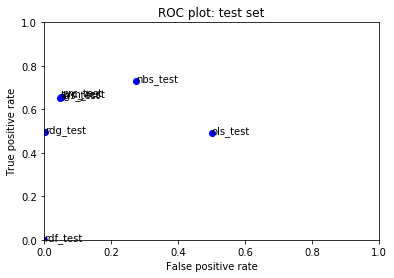

In [32]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

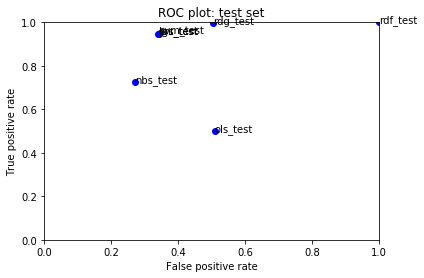

In [34]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FN'] / fit.performance_measures['Pos'], 
             fit.performance_measures['TN'] / fit.performance_measures['Neg'], 'bo')
    plt.text(fit.performance_measures['FN'] / fit.performance_measures['Pos'], 
             fit.performance_measures['TN'] / fit.performance_measures['Neg'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

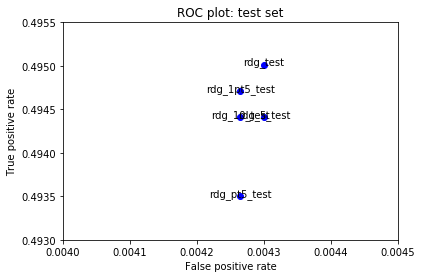

In [89]:
fits = [rdg_performance_test, rdg_pt5_performance_test, rdg_1pt5_performance_test, rdg_5_performance_test, rdg_10_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc, ha = "center")
plt.axis([0.004, .0045, .493, .4955])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [59]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='C:/Users/agbro/Documents/machine-learning/toxic-comments/toxiccomments_train.csv', my_random_seed=22, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 8 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1     

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [60]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.10511308445770222


In [61]:
raw_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,ep_count,hell_count,upper_ratio
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0,4
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,0,4
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0,3
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0,1


In [62]:
my_submission.head()

,id,prediction
0,0000997932d777bf,False
1,000103f0d9cfb60f,False
2,000113f07ec002fd,False
3,0001b41b1c6bb37e,False
4,0001d958c54c6e35,False


In [63]:
my_submission.shape

(159571, 2)

In [64]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('C:/Users/agbro/Documents/machine-learning/toxic-comments/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation